# Marc Schifferle's AI final Project Zero Shot part

## Loading all prerequirements
Loads a pretrained CLIP model for zero-shot image classification.

In [ ]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


### loading the Birds dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset('bentrevett/caltech-ucsd-birds-200-2011')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'bbox'],
        num_rows: 5994
    })
    test: Dataset({
        features: ['image', 'label', 'bbox'],
        num_rows: 5794
    })
})

displaying the first image from the dataset training data

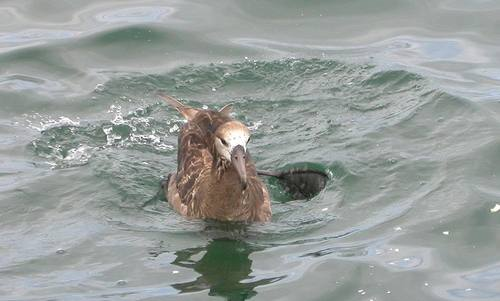

In [3]:
dataset['train'][0]['image']

### Prepare Labels and Lists
Loads the readable bird class names and initializes empty lists to store ground truth and predicted labels.

In [ ]:
from PIL import Image
import io
from tqdm import tqdm

labels_birds = dataset['train'].features['label'].names
print(labels_birds)

true_labels = []
predicted_labels = []

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver

### Run Inference over training set
Loops over all training images, performs zero-shot classification with CLIP, and appends true and predicted labels for later evaluation.

In [ ]:
for i in tqdm(range(len(dataset['train']))):
    
    image = dataset['train'][i]['image']
    
    results = detector(image, candidate_labels=labels_birds)
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    
    predicted_label = sorted_results[0]['label']
    
    # Append the true and predicted labels to the respective lists
    true_labels.append(labels_birds[dataset['train'][i]['label']])
    predicted_labels.append(predicted_label)


100%|██████████| 5994/5994 [20:35<00:00,  4.85it/s]


### Evaluate CLIP Performance
Calculates accuracy, precision, and recall between the predicted and true bird labels, using weighted averaging to account for class imbalance.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='weighted', labels=labels_birds)
recall = recall_score(true_labels, predicted_labels, average='weighted', labels=labels_birds)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.4821
Precision: 0.4908
Recall: 0.4821


/Users/university/ZHAW/aiapplications/abschlussprojekt/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Bird Classifier Web App with Gradio
Now we create a gradio interface.

First we load a fine-tuned ViT model for bird classification. Next we load a zero-shot CLIP model using bird labels as candidate classes.

In [17]:
import gradio as gr
from transformers import pipeline

# Load models
vit_classifier = pipeline("image-classification", model="Marc-Hagenbusch/vit-base-caltech-ucsd-birds-200-2011")
clip_detector = pipeline(model="openai/clip-vit-large-patch14", task="zero-shot-image-classification")

labels_birds = dataset['train'].features['label'].names

def classify_bird(image):
    vit_results = vit_classifier(image)
    
    # Map numeric string labels to actual bird names using labels_birds
    vit_output = {
        labels_birds[int(result['label'])]: result['score']
        for result in vit_results
    }
    
    clip_results = clip_detector(image, candidate_labels=labels_birds)
    clip_output = {
        str(result['label']): result['score']
        for result in clip_results
    }

    return {
        "ViT Classification": vit_output,
        "CLIP Zero-Shot Classification": clip_output
    }


example_images = [
    ["example_images/bird1.png"],
    ["example_images/bird2.png"],
    ["example_images/bird3.png"],
    ["example_images/bird4.png"]
]

iface = gr.Interface(
    fn=classify_bird,
    inputs=gr.Image(type="filepath"),
    outputs=gr.JSON(),
    title="Bird Classification Comparison",
    description="Upload an image of a bird, and compare results from a trained ViT model and a zero-shot CLIP model.",
    examples=example_images
)

iface.launch()

Device set to use mps:0
Device set to use mps:0


* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
